In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
import plotly.graph_objects as go
from fbprophet import Prophet

## Import New York Times's dataset, parse date parameter makes sure the dates are in the proper format, it also helps us to work on this dataset as time series.
The advantage of importing a dataset directly from a URL is that you'll always get an up to date infromation on COVID-19

In [2]:
covid_df=pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-states.csv', parse_dates=True)
covid_df_counties=pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv', parse_dates=True)

In [3]:
#Checking that the dataset is imported correctly and looks good
covid_df.head()

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0

In [4]:
#Dropping the 'fips' column as it is meant for geolocation info, which I'm not using in my analysis (so far)
#covid_df.drop('fips', axis=1, inplace=True)

## This code uses the groupby and sort functions to plot infections and deaths in each state by descending order. We clearly see that New York and New Jersey dwarf other states.

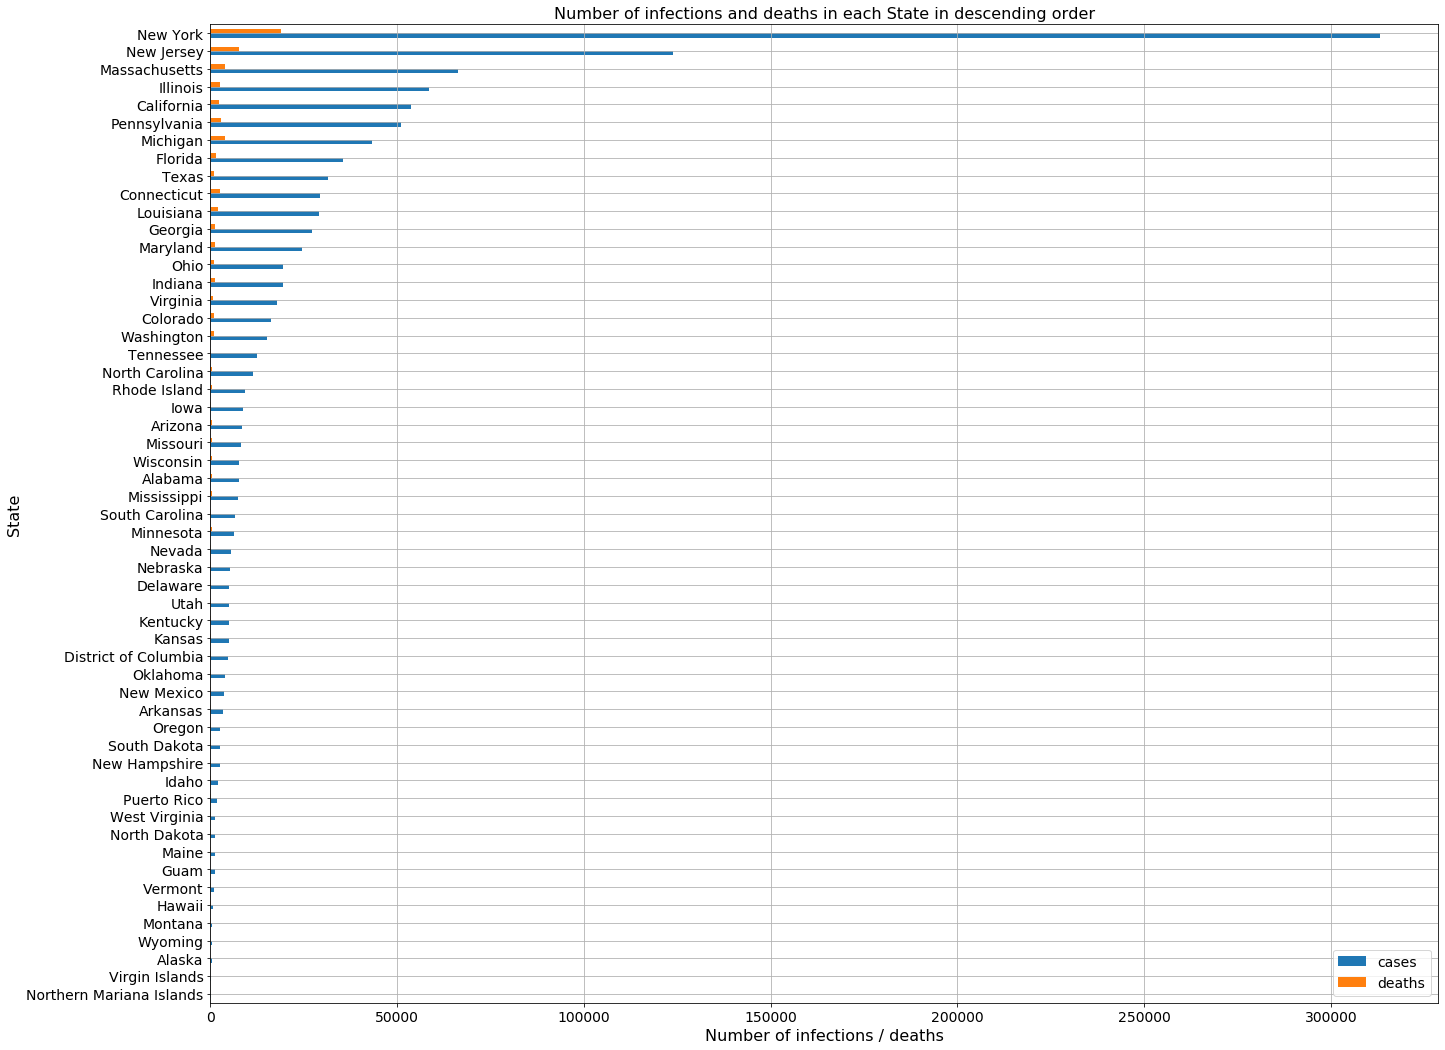

In [5]:

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=True).plot\
(kind='barh', figsize=(22,18), grid=True, fontsize=14)
plt.ylabel('State', fontsize=16)
plt.xlabel('Number of infections / deaths', fontsize=16)
plt.title('Number of infections and deaths in each State in descending order', fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [6]:
#covid_df[['date','state','cases','deaths']].groupby('state').sum().plot(kind='bar', figsize=(25,15))

In [7]:
#ax1=plt.gca()
#covid_df[covid_df['state']=='New York'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax1, label='New York', grid=True)
#covid_df[covid_df['state']=='New Jersey'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax1, label='New Jersey', grid=True)
#ax1.legend()
#plt.show()
#covid_df[covid_df['state']=='Washington'].loc[800:].plot(x='date', figsize=(25,15), kind='line', alpha=0.5, ax=ax1)

## Creating a new dataframe with New York data for separate analysis

In [8]:
NY_df=covid_df[covid_df['state']=='New York'][['state','cases', 'deaths', 'date']]
VA_df=covid_df[covid_df['state']=='Virginia'][['state','cases', 'deaths', 'date']]

In [9]:
#Copying the date column to the index and dropping the date column which reduces the size of our dataframe and makes it easier to read
NY_df.index=NY_df.date
VA_df.index=VA_df.date
NY_df.drop(columns='date', inplace=True)
VA_df.index=VA_df.date
VA_df.drop(columns='date', inplace=True)

In [10]:
#NY_df.cases.astype('int32', copy=False)

In [11]:
#NY_df.index.astype('datetime64[ns]')

## Plotting cumulative cases in New York State

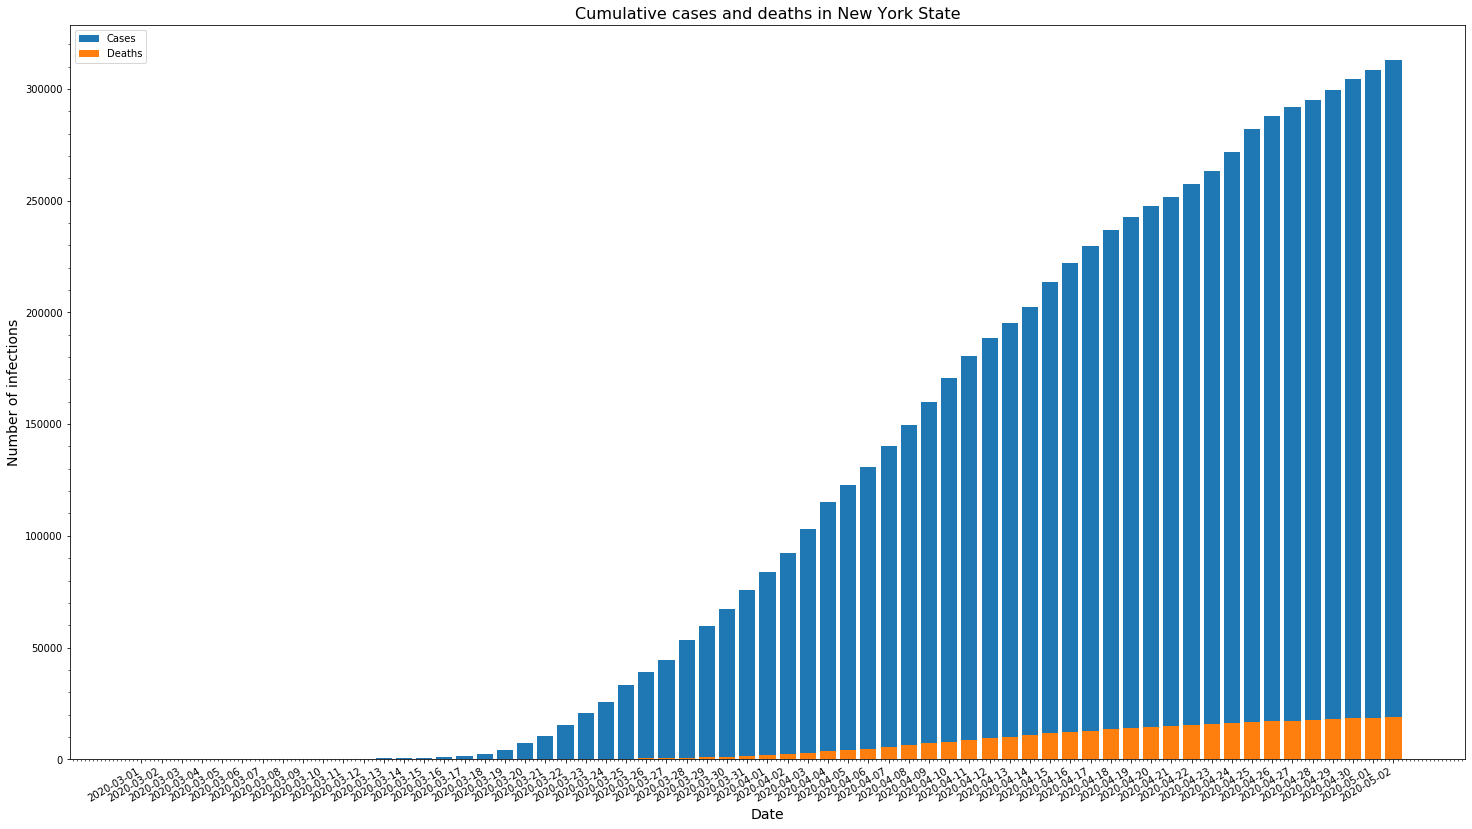

In [12]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.cases, label='Cases')
ax.bar(NY_df.index, NY_df.deaths, label='Deaths')
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of infections', fontsize=14)
plt.title('Cumulative cases and deaths in New York State', fontsize=16)
plt.minorticks_on()
plt.show()

## Since daily fluctuations in number of infections and deaths could confuse analysis, we use below a statistical method of rolling or moving averages to calculate short and long averages which take into account a 3 and a 7 day rolling averages. We will plot the results separately and we can observe that the longer the rolling window, the smoother are the lines that reflect daily cases.

In [13]:

NY_rollshort=NY_df.cases.rolling(window=3)
NY_rolllong=NY_df.cases.rolling(window=7)
NY_df['SMA_short']=NY_rollshort.mean()
NY_df['SMA_long']=NY_rolllong.mean()
NY_df['New_cases']=0
NY_df['New_cases_Short_MA']=0
NY_df['New_cases_Long_MA']=0
NY_df['New_deaths']=0



In [14]:
VA_rolllong=VA_df.cases.rolling(window=7)
VA_df['SMA_long']=VA_rolllong.mean()
VA_df['New_cases']=0
VA_df['New_cases_Long_MA']=0
VA_df['New_deaths']=0

In [15]:
#Veryfying the dataset lenght
#len(NY_df)
#NY_df.loc[:,('cases')][2]

## Update: The below forloop is disabled as it would be inefficient in large datasets to loop thru the whole data. A simple Panda method 'diff()' does the same job of calculate difference between rows.
## The below code 'For loop'(now disabled) is done to calculate daily new cases of infections and deaths since the data set provides cumulative daily case. Hence a simple for loop is done to calculate the difference in infections between a day and the preceding day for infections and deaths. The same is done for the 3 and 7 day averages.

In [16]:
NY_df.New_cases=NY_df.cases.diff()
NY_df.New_cases_Short_MA=NY_df.SMA_short.diff()
NY_df.New_cases_Long_MA=NY_df.SMA_long.diff()
NY_df.New_deaths=NY_df.deaths.diff()
NY_df.fillna(0, inplace=True) # Replacing null values with zeros in the dataset to avoid any issues with visualization libraries

In [17]:
VA_df.New_cases=VA_df.cases.diff()
VA_df.New_cases_Long_MA=VA_df.SMA_long.diff()
VA_df.New_deaths=VA_df.deaths.diff()
VA_df.fillna(0, inplace=True)

In [18]:
# Disabled forloop code kept for reference. It was replaced by the more efficient diff() method
#for i in range(len(NY_df)):
#    if NY_df.cases[i]==1:
#        i+=1
#    else:
#        NY_df.New_cases[i]=NY_df.cases[i]-NY_df.cases[i-1]
#        NY_df.New_deaths[i]=NY_df.deaths[i]-NY_df.deaths[i-1]
#        NY_df.New_cases_Short_MA[i]=NY_df.SMA_short[i]-NY_df.SMA_short[i-1]
#        NY_df.New_cases_Long_MA[i]=NY_df.SMA_long[i]-NY_df.SMA_long[i-1]

In [19]:
NY_df.cases[-1]

313008

## We plot the daily new cases of infections and deaths in New York State using matplotlib. In order to metigate day-to-day fluctuations, the blue line tracks a 7-days rolling average of new infections to show a more general trend of the 'curve' which appears to be on the downward trend since April 15. A few texts combined with variables are also plotted on the chart to reflect important changes such as change in new infections and deaths.

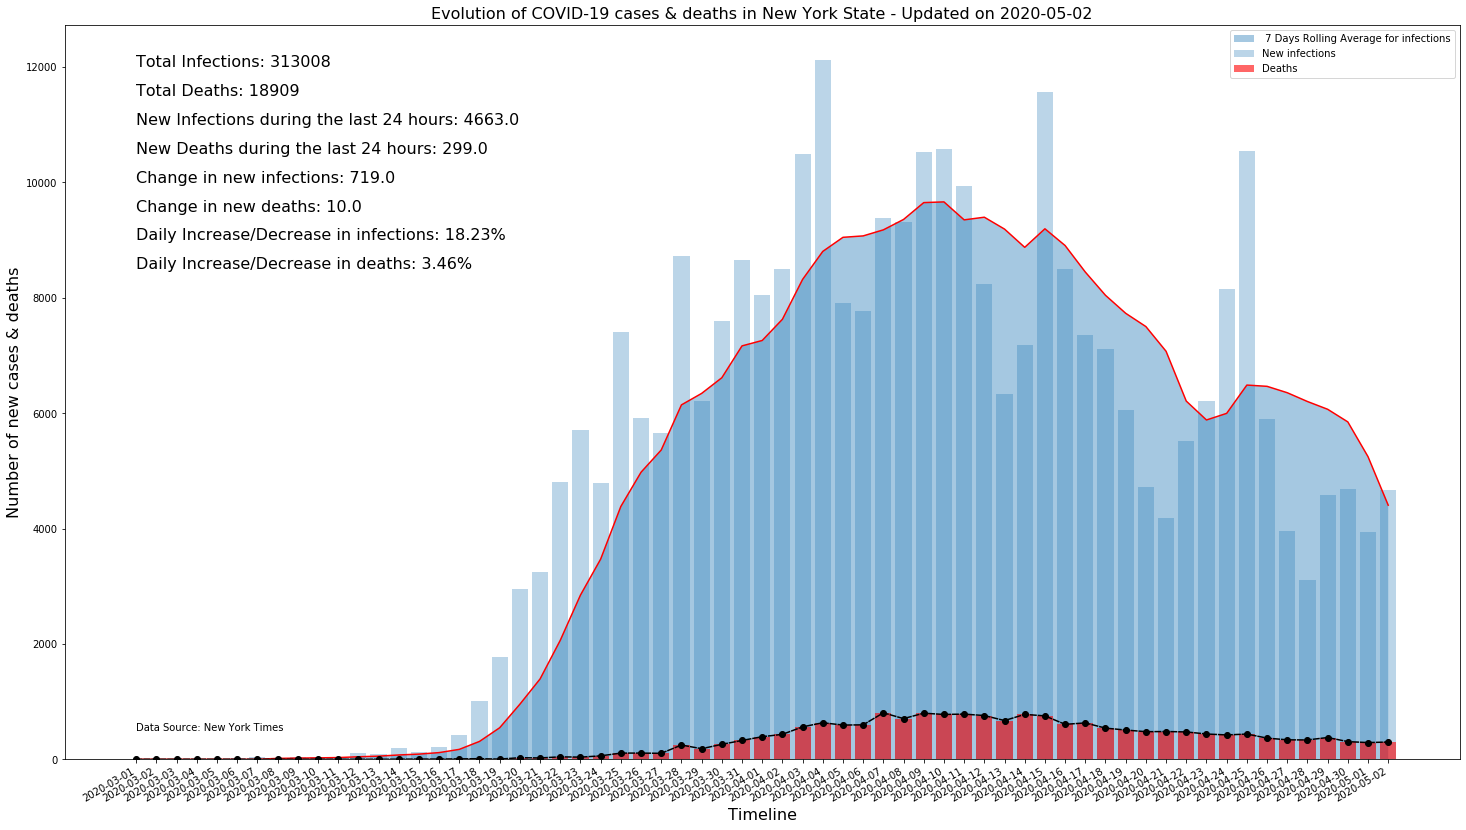

In [20]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.New_cases, alpha=0.3, label='New infections')
ax.bar(NY_df.index, NY_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(NY_df.index, NY_df.New_cases_Long_MA, labels=[' 7 Days Rolling Average for infections'], alpha=0.4 )
ax.plot(NY_df.index, NY_df.New_cases_Long_MA, color='red')
ax.plot(NY_df.index, NY_df.New_deaths, 'ko--', dash_capstyle='projecting' )
ax.text(0,12000,s='Total Infections: '+str(NY_df.cases[-1]), fontsize=16)
ax.text(0,11500,s='Total Deaths: '+str(NY_df.deaths[-1]), fontsize=16)
ax.text(0,11000,s='New Infections during the last 24 hours: '+str(NY_df.New_cases[-1]), fontsize=16)
ax.text(0,10500,s='New Deaths during the last 24 hours: '+str(NY_df.New_deaths[-1]), fontsize=16)
ax.text(0,10000,s='Change in new infections: '+str(NY_df.New_cases[-1]-NY_df.New_cases[-2]), fontsize=16)
ax.text(0,9500,s='Change in new deaths: '+str(NY_df.New_deaths[-1]-NY_df.New_deaths[-2]), fontsize=16)
ax.text(0,9000,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((NY_df.New_cases[-1]-NY_df.New_cases[-2])/NY_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method to round the percentage decimals
ax.text(0,8500,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((NY_df.New_deaths[-1]-NY_df.New_deaths[-2])/NY_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(0,500,s='Data Source: New York Times')
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in New York State - Updated on '+str(NY_df.index[-1]), fontsize=16)
plt.savefig('COVID19NYC.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## We do the same chart for the State of Virginia

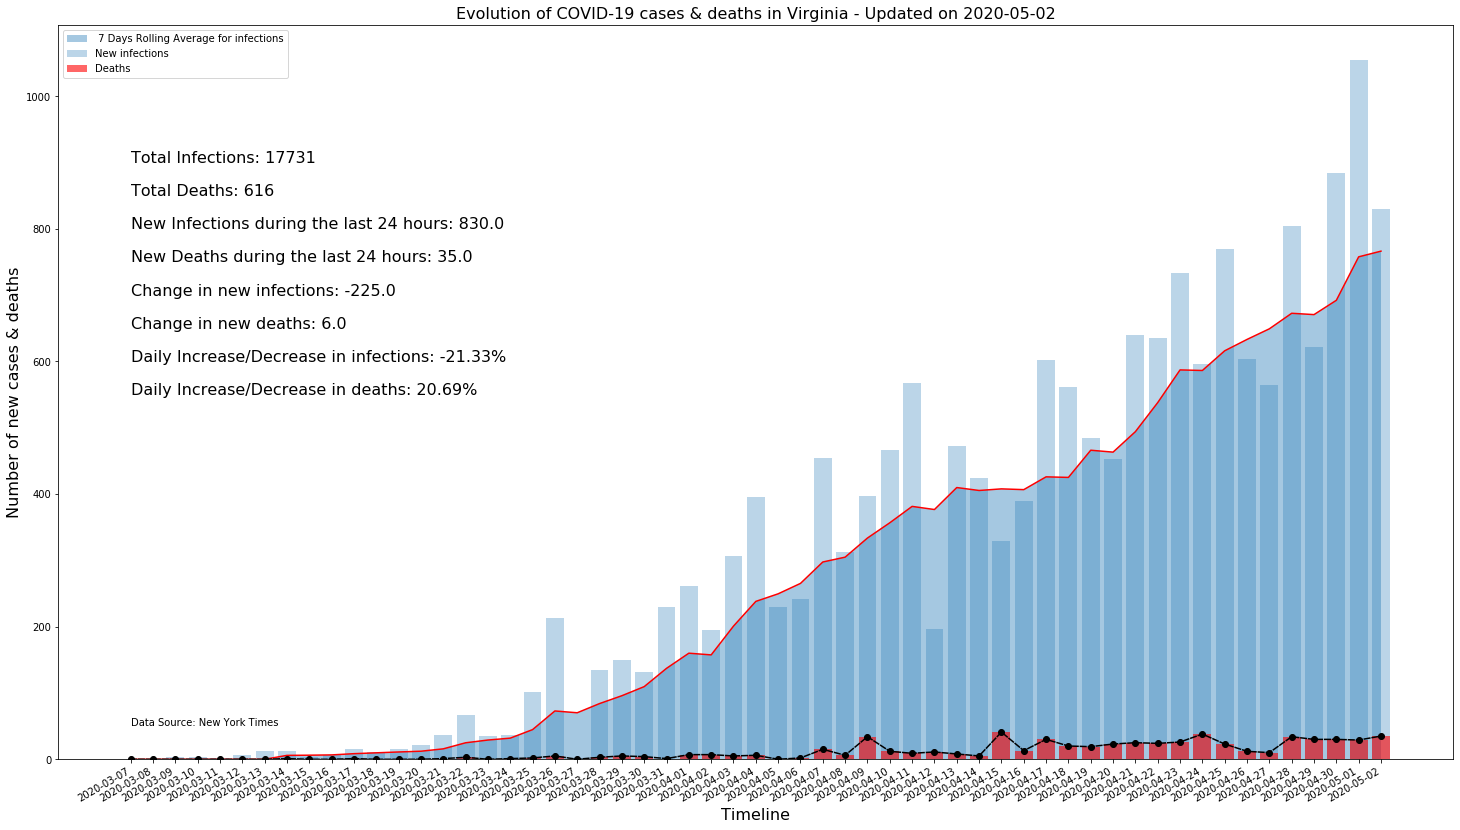

In [21]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(VA_df.index, VA_df.New_cases, alpha=0.3, label='New infections')
ax.bar(VA_df.index, VA_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.stackplot(VA_df.index, VA_df.New_cases_Long_MA, labels=[' 7 Days Rolling Average for infections'], alpha=0.4 )
ax.plot(VA_df.index, VA_df.New_cases_Long_MA, color='red')
ax.plot(VA_df.index, VA_df.New_deaths, 'ko--', dash_capstyle='projecting' )
ax.text(0,900,s='Total Infections: '+str(VA_df.cases[-1]), fontsize=16)
ax.text(0,850,s='Total Deaths: '+str(VA_df.deaths[-1]), fontsize=16)
ax.text(0,800,s='New Infections during the last 24 hours: '+str(VA_df.New_cases[-1]), fontsize=16)
ax.text(0,750,s='New Deaths during the last 24 hours: '+str(VA_df.New_deaths[-1]), fontsize=16)
ax.text(0,700,s='Change in new infections: '+str(VA_df.New_cases[-1]-VA_df.New_cases[-2]), fontsize=16)
ax.text(0,650,s='Change in new deaths: '+str(VA_df.New_deaths[-1]-VA_df.New_deaths[-2]), fontsize=16)
ax.text(0,600,s='Daily Increase/Decrease in infections: '+'{0:.2f}'.format(((VA_df.New_cases[-1]-VA_df.New_cases[-2])/VA_df.New_cases[-2]*100))+'%', fontsize=16) # Note the use of the format() method
ax.text(0,550,s='Daily Increase/Decrease in deaths: '+'{0:.2f}'.format(((VA_df.New_deaths[-1]-VA_df.New_deaths[-2])/VA_df.New_deaths[-2]*100))+'%', fontsize=16)
ax.text(0,50,s='Data Source: New York Times')
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in Virginia - Updated on '+str(VA_df.index[-1]), fontsize=16)
plt.savefig('COVID19VA.pdf', bbox_inches='tight') # This code saves the plot to a PDF file
plt.show()

## The below chart is generated with Plotly Express library, with a main advantage that it's an interactive chart and easy to generate mainly inteded for tidy date! Just hover the mouse over the bard and you will be able to read the details of each day & many other functions!

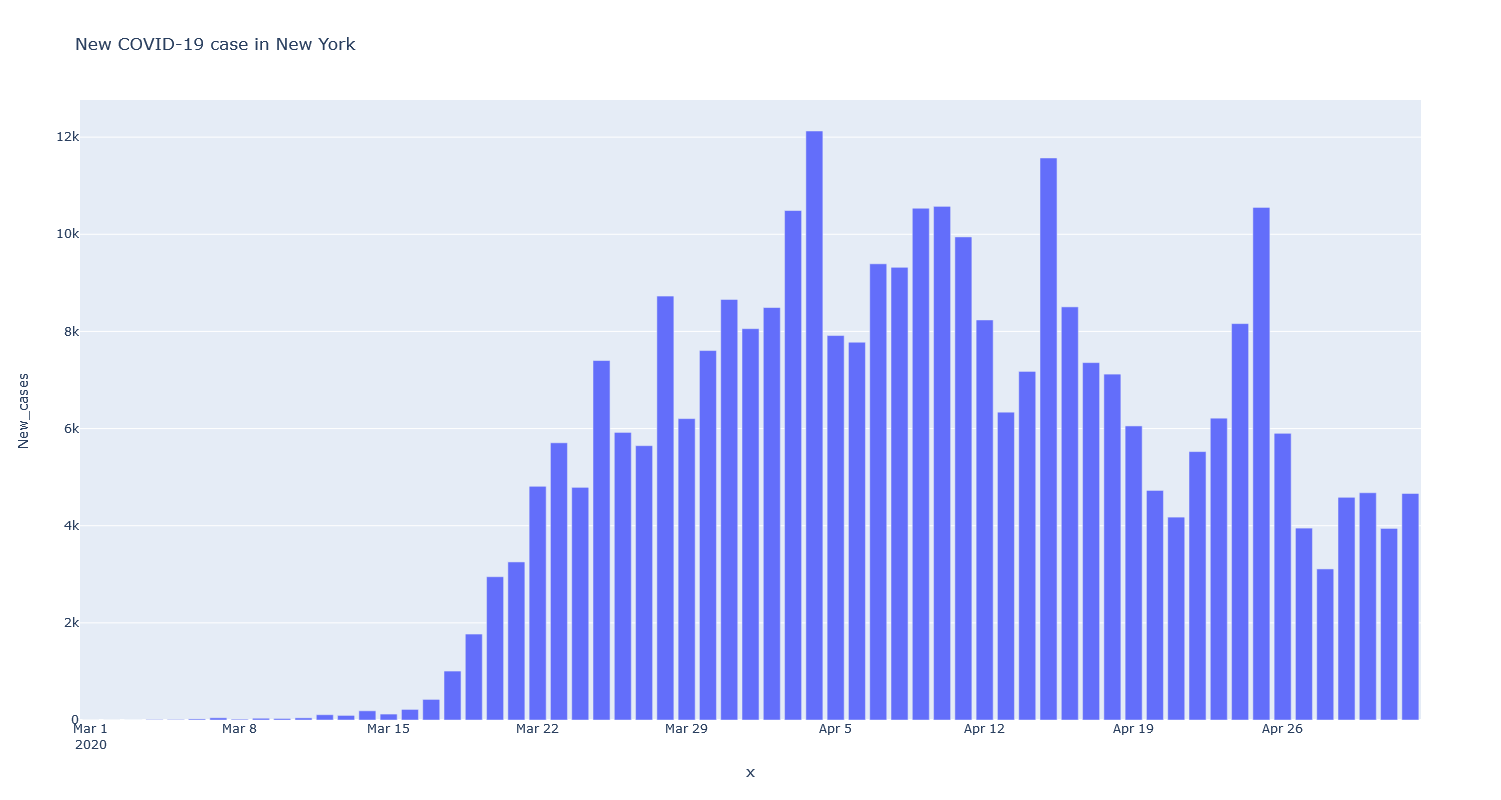

In [22]:
fig = px.bar(data_frame=NY_df, x=NY_df.index, y='New_cases', title='New COVID-19 case in New York', width=1400, height= 800)
fig.show()

## This chart is done using the standard Plotly library using the 'go.Figure' method. This was allows us to use multiple layers as illustrated-below

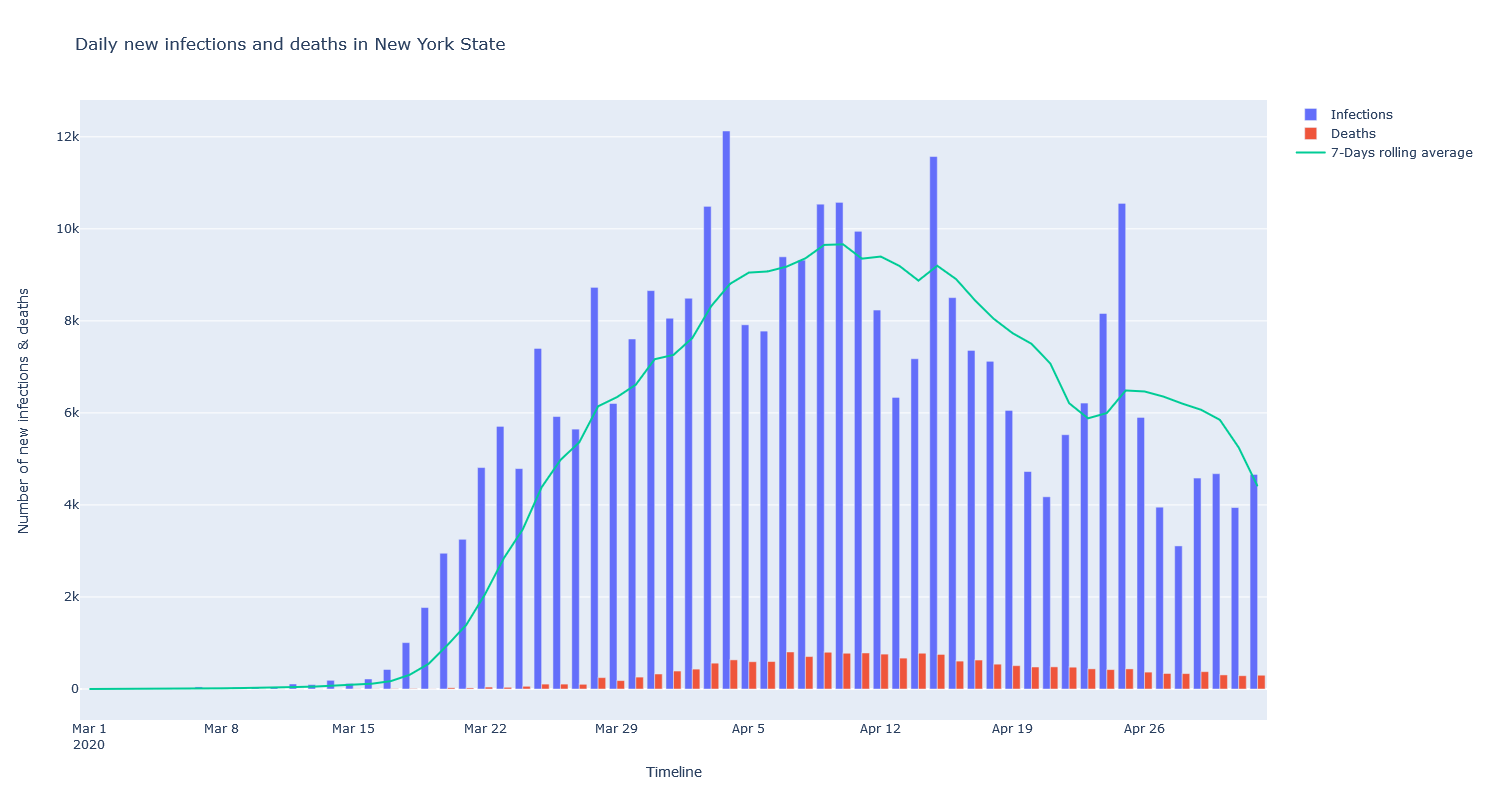

In [23]:
fig=go.Figure()
fig.add_trace(go.Bar(x=NY_df.index, y=NY_df.New_cases, name='Infections'))
fig.add_trace(go.Bar(x=NY_df.index, y=NY_df.New_deaths, name='Deaths'))
fig.add_trace(go.Scatter(x=NY_df.index, y=NY_df.New_cases_Long_MA, name='7-Days rolling average'))
fig.update_layout(title='Daily new infections and deaths in New York State', xaxis_title='Timeline', yaxis_title='Number of new infections & deaths',  width=1400, height= 800)

## Below is a simple use of the Panda Groupby function with sorting parameter. Notice that we use the 'last()' method to use the last row of each group since our dataset has cumulative COVID-19 infections in its rows.

In [85]:
#Total cases & deaths by State sorted descending

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=False)

cases  deaths
state                                   
New York                  313008   18909
New Jersey                123717    7742
Massachusetts              66263    3846
Illinois                   58505    2576
California                 53753    2213
Pennsylvania               51071    2794
Michigan                   43191    4020
Florida                    35455    1363
Texas                      31430     875
Connecticut                29287    2436
Louisiana                  29140    1950
Georgia                    27268    1161
Maryland                   24473    1156
Ohio                       19335    1021
Indiana                    19295    1115
Virginia                   17731     616
Colorado                   16118     830
Washington                 15253     833
Tennessee                  12445     219
North Carolina             11514     428
Rhode Island                9289     296
Iowa                        8641     175
Arizona                     8364     353
Missouri                    8154     373
Wisconsin                   7660     334
Alabama                     7611     288
Mississippi                 7441     291
South Carolina              6489     267
Minnesota                   6228     395
Nevada                      5390     257
Nebraska                    5333      76
Delaware                    5038     168
Utah                        4981      49
Kentucky                    4881     252
Kansas                      4838     140
District of Columbia        4797     240
Oklahoma                    3851     238
New Mexico                  3732     139
Arkansas                    3372      72
Oregon                      2635     109
South Dakota                2588      21
New Hampshire               2429      84
Idaho                       1908      64
Puerto Rico                 1755      54
West Virginia               1184      50
North Dakota                1153      24
Maine                       1152      56
Guam                        1113       6
Vermont                      886      51
Hawaii                       611      16
Montana                      455      16
Wyoming                      429       7
Alaska                       363       7
Virgin Islands                66       4
Northern Mariana Islands      14       2

## Below is the Autocorrelation plot. Autocorrelation is a metric that measures how correlated is a given data or array. The closer it gets to zero the more correlated it is. Once the bars in the chart below sink in the blue shade, it means that there is a good possibility that the data is correlated or in other words its not random. I'm yet to analyse why would a pandemic data start with weak correlation and then tend to form a stronger correlation with time. My initial theory is that there is a stronger correlation simply because the pandemic 'curve' was just recently flattening and the correlation will start to weaken once numbers of infections starts to decrease. 

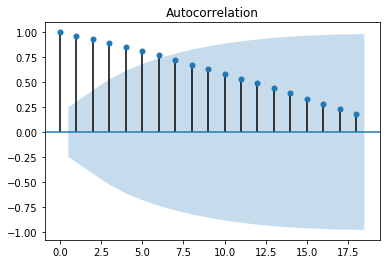

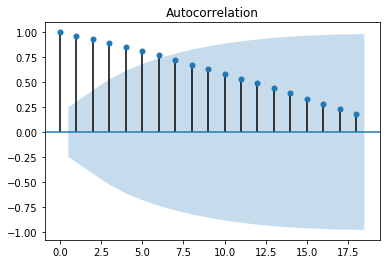

In [24]:
plot_acf(NY_df.cases)

## Below are two forecasting attempts using ARIMA and Facebook's Prophet libraty. Both seemed to be incompatible with epedimiological data. The ARMIA model went on an exponential increase as soon as we went with out of sample forcasting, while the 'Prophet' seemed to be using an incremental seasonal trent in forcasting future data making it a bad for such data.

## ARIMA

In [29]:
NY_df1=NY_df.iloc[2:] # I trimmed the DF here as rows with zero new cases create infinite values when logaritmizing data

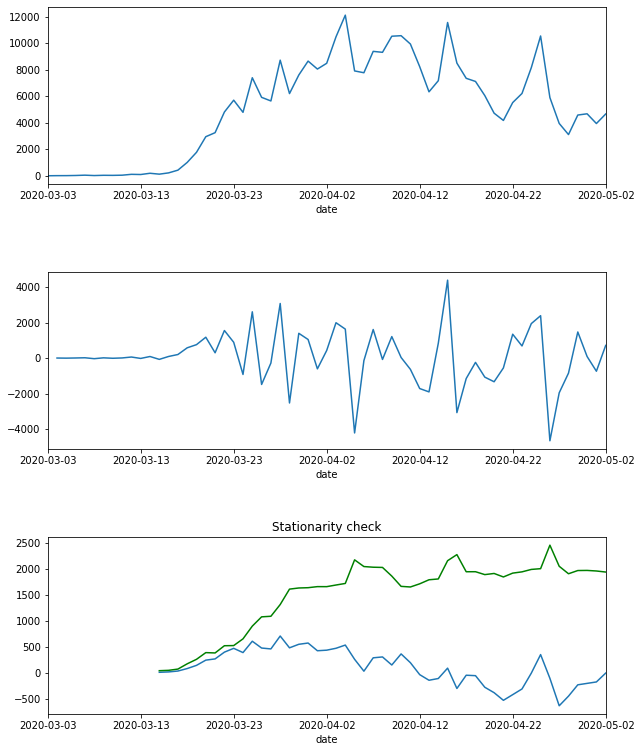

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 13))

# Plot the NY_DF_cases numbers
NY_df1.New_cases.plot(ax = ax1)

# Plot differentiated signal
NY_df1.New_cases.diff().plot(ax = ax2)

# PLot the moving average and moving standard deviation
NY_df1.New_cases.diff().rolling(12).mean().plot(ax = ax3, title = 'Stationarity check')
NY_df1.New_cases.diff().rolling(12).std().plot(ax = ax3, color = 'green')

# Plot
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [31]:
NY_df1['New_cases_log'] = np.log(NY_df1['New_cases'])

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Despite logaritmizing the data, the signal was not very stationary and hence the model was behaving erratically

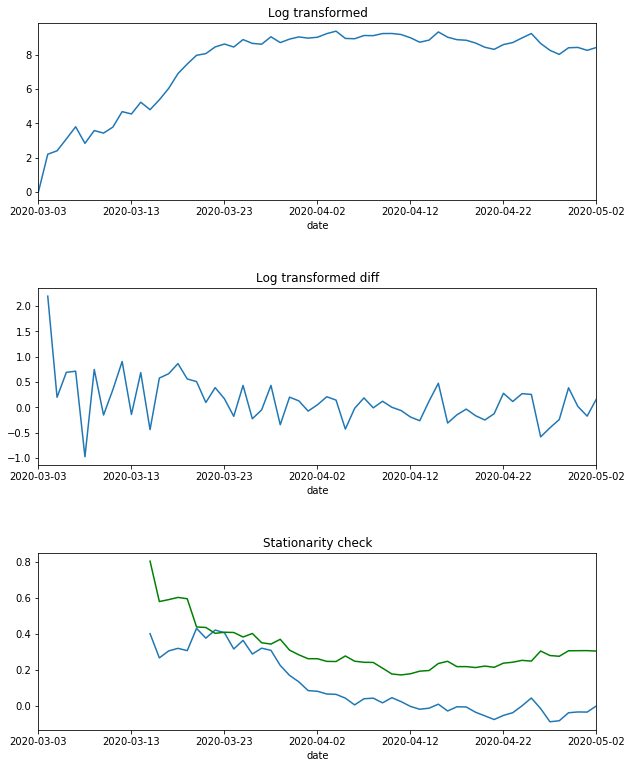

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 13))

# Plot the NY_DF_cases numbers
NY_df1.New_cases_log.plot(ax = ax1, title='Log transformed')

# Plot differentiated signal
NY_df1.New_cases_log.diff().plot(ax = ax2, title='Log transformed diff')

# PLot the moving average and moving standard deviation
NY_df1.New_cases_log.diff().rolling(12).mean().plot(ax = ax3, title = 'Stationarity check')
NY_df1.New_cases_log.diff().rolling(12).std().plot(ax = ax3, color = 'green')

# Plot
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [33]:
n = np.int(len(NY_df1) * 0.7)
train, test = NY_df1.iloc[:n], NY_df1.iloc[n:]

## The below Autocorrelation and partial autocorrelation plot are needed to determine the order of the ARIMA fit, particularely the P and the Q paremeters. They are basically detemined by seeing the nearest AC and PAC to zero and hence in the example below we chose 15 for the P (c.f. the autocorrelation plot) value and 11 (c.f. see the partial autocorrelation plot) for the Q value

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



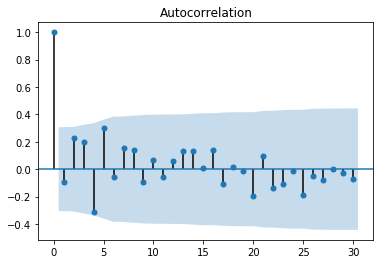

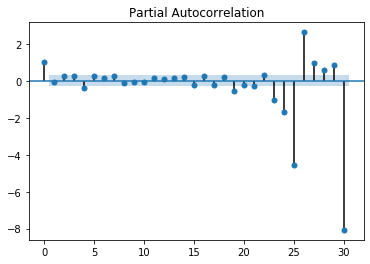

In [34]:
p1 = tsaplots.plot_acf(train.New_cases_log.diff().dropna(), lags=30, alpha=0.05)
p2 = tsaplots.plot_pacf(train.New_cases_log.diff().dropna(), lags=30, alpha=0.05)
plt.show()

In [35]:
arima = ARIMA(train.New_cases_log.dropna().astype(float), order=(15,1,11))
arima_fit = arima.fit(disp=1, maxiter=100)
print(arima_fit.summary())

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                             ARIMA Model Results                              
Dep. Variable:        D.New_cases_log   No. Observations:                   41
Model:               ARIMA(15, 1, 11)   Log Likelihood                 -17.358
Method:                       css-mle   S.D. of innovations              0.272
Date:                Sun, 03 May 2020   AIC                             90.715
Time:                        15:21:24   BIC                            138.695
Sample:                    03-04-2020   HQIC                           108.187
                         - 04-13-2020                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1933      0.020      9.472      0.000       0.153       0.233
ar.L1.D.New_cases_log      0.5862        nan        nan        nan         nan         nan
ar.L

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\amg_m\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

C:\Users\amg_m\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

C:\Users\amg_m\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



In [36]:
p, err, conf = arima_fit.forecast()
print ('Predicted no. of infections [log]: %1.2f' %  p)
print ('Standard error of the prediction: %1.2f' % err)
print ('Confidence interval: (%1.2f, %1.2f)' % (conf[0][0], conf[0][1]))

y_hat = np.exp(p)
y = test.New_cases[0]

Predicted no. of infections [log]: 8.81
Standard error of the prediction: 0.27
Confidence interval: (8.27, 9.34)


In [37]:
print ('Predicted number of infections: %1.2f' % y_hat)
print ('Actual number of infections: %i' % y)
print ('Absolute error: %1.2f' % np.abs(y_hat - y))
print ('Relative error %1.2f%%' % (np.abs(y_hat - y) / y * 100))

Predicted number of infections: 6676.95
Actual number of infections: 7177
Absolute error: 500.05
Relative error 6.97%


In [38]:
# Define the history
hist = list(train.New_cases_log.dropna().astype(float))

# Initialize container for predictions
pred = []
for i in range(len(test)):
    # Initalize the model
    arima = ARIMA(hist, order=(15,1,1))
    #Fit the model on the available history
    arima_fit = arima.fit(disp=1, maxiter=500)
    # Take the prediction
    pred.append(arima_fit.forecast()[0][0])   
    # Expand the history
    hist.append(test.New_cases_log[i])

## The below plot shows a good fit for an insample prediction with a small deviation from the actual data

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



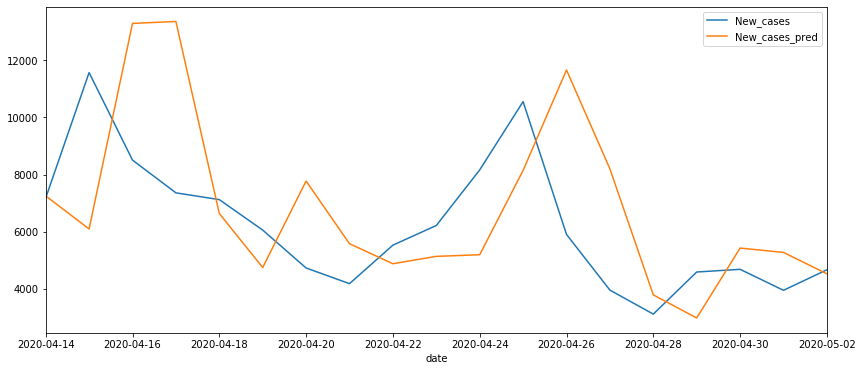

In [39]:
test['New_cases_pred'] = np.exp(pred)
test[['New_cases', 'New_cases_pred']].plot(figsize=(14,6))

In [40]:
arima_fit.forecast(3)[0]

array([8.41686635, 7.98042352, 7.89795998])

##However, once we go out of sample, the prediction grows exponatialy

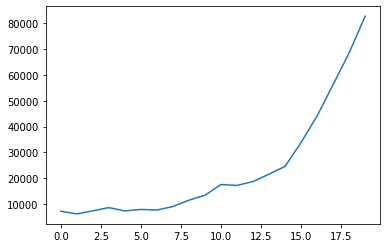

In [101]:
prediction_data=np.exp(arima_fit.forecast(steps=20)[0]) # We generated 20 days of out of sample prediction and the model behaved alright for about 12 days before going of
plt.plot(prediction_data)

In [42]:
arima = ARIMA(train.New_cases_log.dropna().astype(float), order=(15,1,1))
arima_fit = arima.fit(disp=1, maxiter=100)

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\amg_m\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



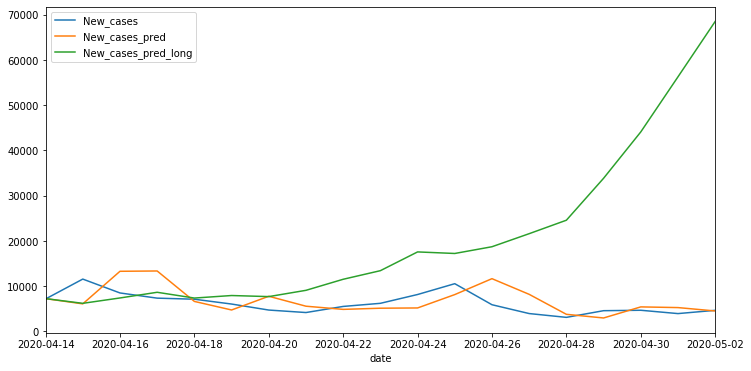

In [43]:
pred,_,_ = arima_fit.forecast(steps=len(test))
test['New_cases_pred_long'] = np.exp(pred)
test[['New_cases', 'New_cases_pred', 'New_cases_pred_long']].plot(figsize=(12,6))

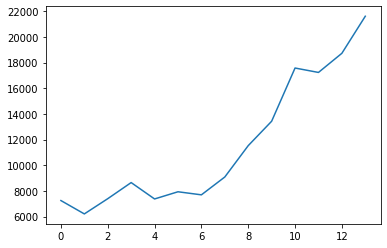

In [61]:
prediction_data=np.exp(arima_fit.forecast(steps=14)[0])
plt.plot(prediction_data)

## Prophet (Built by Facebook). This library required your dataframe to have a date column called 'ds' and a 'y' column containing the numeric data you want to fit the model with

In [87]:
test_df=NY_df[['New_cases']] # Since the dataframe's index is the date, we only need the new cases column

In [88]:
test_df.rename(columns={'date':'ds','New_cases':'y'}, inplace=True)
test_df['ds']=test_df.index # Copied the index to the 'ds' date column as required by Propher

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
test_df['ds']=pd.to_datetime(test_df['ds'])

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
test_df # Making sure all looks good as per the model's requirement

y          ds
date                          
2020-03-01     0.0  2020-03-01
2020-03-02     0.0  2020-03-02
2020-03-03     1.0  2020-03-03
2020-03-04     9.0  2020-03-04
2020-03-05    11.0  2020-03-05
...            ...         ...
2020-04-28  3110.0  2020-04-28
2020-04-29  4585.0  2020-04-29
2020-04-30  4679.0  2020-04-30
2020-05-01  3944.0  2020-05-01
2020-05-02  4663.0  2020-05-02

[63 rows x 2 columns]

In [90]:
m=Prophet() #Initiated a Propher instance

In [91]:
m.fit(test_df) # Model is fit with the dataframe e.g. trained

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [93]:
future=m.make_future_dataframe(periods=30) # A very useful function which builds a new dataframe with future dates to integrate the forcasted data. Here we chose to go 30 days into the future.

In [94]:
future

ds
0  2020-03-01
1  2020-03-02
2  2020-03-03
3  2020-03-04
4  2020-03-05
..        ...
88 2020-05-28
89 2020-05-29
90 2020-05-30
91 2020-05-31
92 2020-06-01

[93 rows x 1 columns]

In [95]:
forecast = m.predict(future) # We initiated forecasting and passed the future dataframe as a parameter
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds          yhat    yhat_lower    yhat_upper
88 2020-05-28  12240.965396   8945.821997  15733.186558
89 2020-05-29  12574.737506   8952.176930  16120.523906
90 2020-05-30  13394.844843  10038.036151  16829.176838
91 2020-05-31  12354.104095   8566.897042  15788.009960
92 2020-06-01  12031.444724   8368.960242  15703.588339

## Below plot illustrates the actual data in red dotted line while the solid lines represented the upper, lower, and mid y_hat (forecast) ranges generated by the propher.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


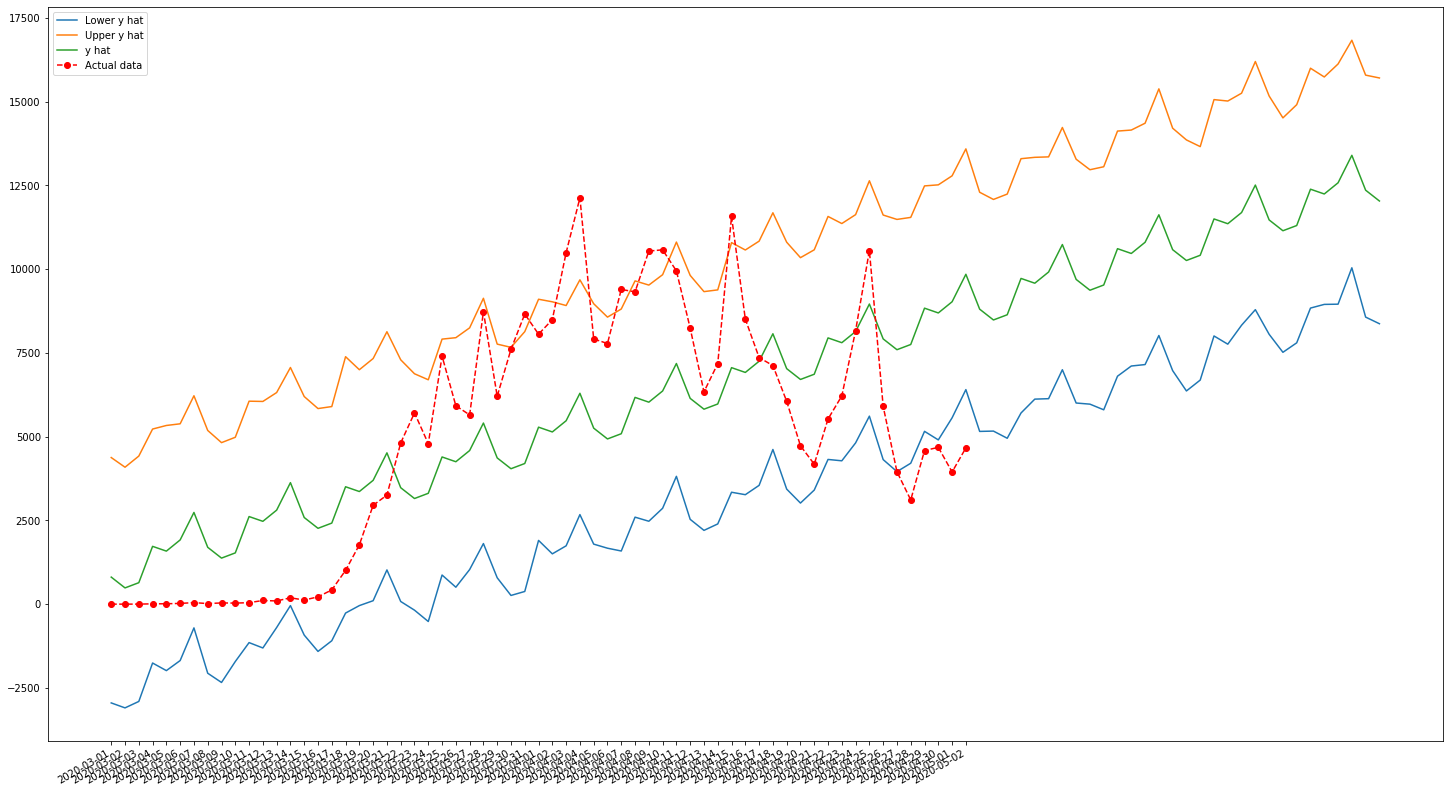

In [99]:
fig, ax=plt.subplots(figsize=(25,15))
plt.plot(forecast.yhat_lower, label='Lower y hat')
plt.plot(forecast.yhat_upper, label='Upper y hat')
plt.plot(forecast.yhat, label='y hat')
plt.plot(test_df.y,  'ro--', label='Actual data')
plt.legend()
fig.autofmt_xdate()
plt.show()

## The below plot is buil-in in the Prophet model, it illustrates the same data

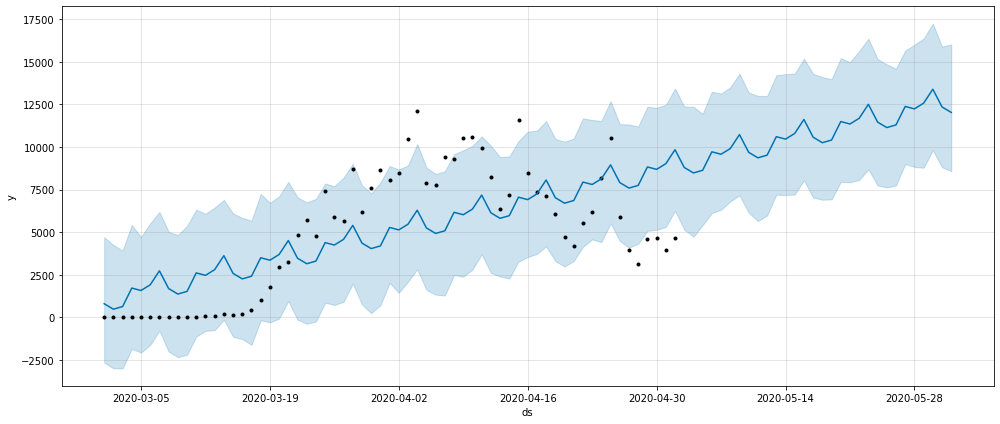

In [70]:
fig1=m.plot(forecast, figsize=(14,6))